# 10. Multinomial Naive Bayes (MNB)

In [24]:
# 1. Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [25]:
df = pd.read_csv("../2_data/X_train_outlierremoved.csv")

# Load the dataset

# Read the dataset from CSV files
X_train = pd.read_csv("../2_data/X_train_outlierremoved.csv")
X_test = pd.read_csv("../2_data/X_test.csv")
y_train = pd.read_csv("../2_data/y_train_outlierremoved.csv")
y_test = pd.read_csv("../2_data/y_test.csv")

# Ensure the target variable has the correct shape (1D array)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3885, 91)
X_test shape: (1409, 91)
y_train shape: (3885,)
y_test shape: (1409,)


## Feature Preparation

In Multinomial Naive Bayes, we focus on discrete features, particularly those that represent counts or frequencies.
For this case, we are dealing with boolean features that are encoded as integers.

Ensure that all features are boolean encoded as integers (0 or 1).
Remove any features that are not boolean or discrete, as they do not fit the assumptions of the Multinomial Naive Bayes model.
Normalize the feature values if necessary to ensure they are on a similar scale, although this is less critical for boolean features.

By following these steps, we can ensure that the features are appropriately prepared for the Multinomial Naive Bayes classifier, which will help in achieving better performance and accuracy.

In [26]:
category_columns = []
int_columns = []
float_columns = []
object_columns = []
category_columns = []

for col in df.columns:
    dtype = df[col].dtype
    if dtype == 'object':
        object_columns.append(col)
    elif dtype == 'int64':
        int_columns.append(col)
    elif dtype == 'float64':
        float_columns.append(col)
    else:
        category_columns.append(col)  

print("Integer Columns (int64):")
for col in int_columns:
    print(f" - {col}")

print("\nFloat Columns (float64):")
for col in float_columns:
    print(f" - {col}")

print("\nObject Columns (object):")
for col in object_columns:
    print(f" - {col}")

print("\nCategory Columns (category):")
for col in category_columns:
    print(f" - {col}")

Integer Columns (int64):
 - Count
 - Gender
 - Age
 - Under 30
 - Senior Citizen
 - Married
 - Dependents
 - Number of Dependents
 - City
 - Zip Code
 - Referred a Friend
 - Number of Referrals
 - Tenure in Months
 - Phone Service
 - Multiple Lines
 - Internet Service
 - Avg Monthly GB Download
 - Online Security
 - Online Backup
 - Device Protection Plan
 - Premium Tech Support
 - Streaming TV
 - Streaming Movies
 - Streaming Music
 - Unlimited Data
 - Paperless Billing
 - Total Extra Data Charges
 - Satisfaction Score
 - CLTV
 - Partner
 - Tenure
 - Country_United States
 - State_California
 - Quarter_Q3
 - Offer_Offer A
 - Offer_Offer B
 - Offer_Offer C
 - Offer_Offer D
 - Offer_Offer E
 - Internet Type_Cable
 - Internet Type_DSL
 - Internet Type_Fiber Optic
 - Contract_Month-to-Month
 - Contract_One Year
 - Contract_Two Year
 - Payment Method_Bank Withdrawal
 - Payment Method_Credit Card
 - Payment Method_Mailed Check
 - Device Protection_No
 - Device Protection_No internet service

In [27]:
# Binary features (the 0/1 boolean encoded ones)
binary_features = [col for col in df.columns if df[col].dtype == 'int64' and df[col].nunique() == 2]

print("\nBinary Features:")
print(binary_features)

print(f"Number of binary features: {len(binary_features)}")


Binary Features:
['Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Partner', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'Internet Type_Cable', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card', 'Payment Method_Mailed Check', 'Device Protection_No', 'Device Protection_No internet service', 'Device Protection_Yes', 'Tech Support_No', 'Tech Support_No internet service', 'Tech Support_Yes', 'Internet_Phone_Bundle', 'Digital_Payments', 'Traditional_Payments', 'Revenue_Cluster_Low', 'Revenue_Cluster_Medium', 'Revenue_Cluster_High', 'Monthly_Charges_18.

Note: The integer features do not need to be scaled as they are already on the same scale. We now want to delete highly correlated features.

Strongly correlated pairs of features and their correlation values (sorted):
Married and Partner: 1.0
Device Protection Plan and Device Protection_Yes: 1.0
Premium Tech Support and Tech Support_Yes: 1.0
Payment Method_Mailed Check and Traditional_Payments: 1.0
Device Protection_No internet service and Tech Support_No internet service: 1.0
Internet Service and Unlimited Data: 0.9848956954804701
Married and Referred a Friend: 0.9428756061409814
Referred a Friend and Partner: 0.9428756061409814
Device Protection_No internet service and Monthly_Charges_18.25-35.5: 0.934803758261633
Tech Support_No internet service and Monthly_Charges_18.25-35.5: 0.934803758261633
Streaming Movies and Streaming Music: 0.855230238662137
Internet Service and Internet_Phone_Bundle: 0.8021669511755353
Unlimited Data and Internet_Phone_Bundle: 0.7880060588925852
Internet Type_Fiber Optic and Monthly_Charges_89.86-118.75: 0.6544372159551806
Internet Type_Fiber Optic and Internet_Phone_Bundle: 0.6044873782916858
S

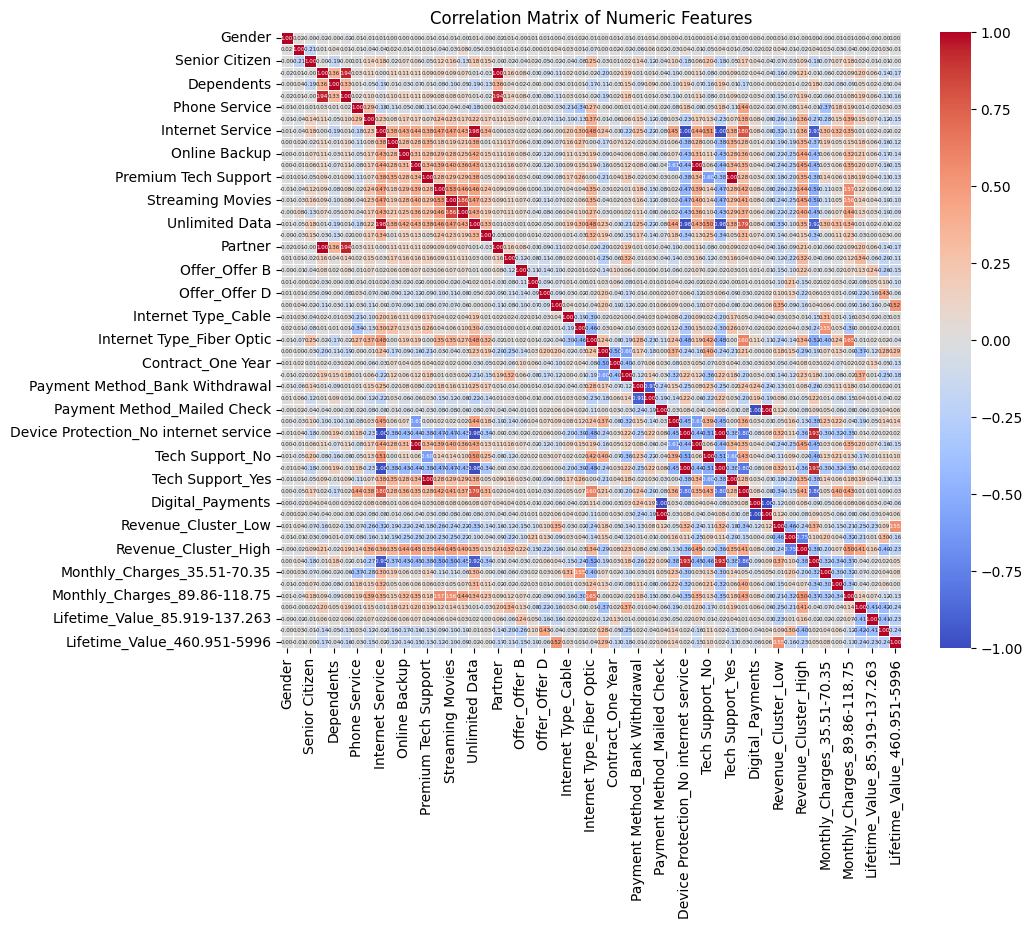

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame
numeric_features = df[binary_features]

# Compute the correlation matrix among numeric features
correlation_matrix = numeric_features.corr()

# Set the upper triangle of the correlation matrix (including the diagonal) to NaN
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find strongly correlated pairs of features (using a threshold, e.g., 0.5)
strongly_correlated_pairs = []
for i in range(len(upper_triangle.columns)):
    for j in range(i + 1, len(upper_triangle.columns)):
        if upper_triangle.iloc[i, j] > 0.5:
            feature_i, feature_j = upper_triangle.columns[i], upper_triangle.columns[j]
            correlation_value = upper_triangle.iloc[i, j]
            strongly_correlated_pairs.append((feature_i, feature_j, correlation_value))

# Sort strongly correlated pairs in decreasing order of correlation values
strongly_correlated_pairs.sort(key=lambda x: x[2], reverse=True)

# Display strongly correlated pairs and their correlation values
print("Strongly correlated pairs of features and their correlation values (sorted):")
for pair in strongly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 4})
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Highly Correlated Features and what we do with them**

1. **Married and Partner: 1.0**
    - **Delete:** Partner
    - **Reason:** Both features represent similar information about the marital status. Keeping "Married" is more intuitive.

2. **Device Protection Plan and Device Protection_Yes: 1.0**
    - **Delete:** Device Protection_Yes
    - **Reason:** "Device Protection Plan" is more descriptive and easier to understand.

3. **Premium Tech Support and Tech Support_Yes: 1.0**
    - **Delete:** Tech Support_Yes
    - **Reason:** "Premium Tech Support" provides a clearer description of the service.

4. **Payment Method_Mailed Check and Traditional_Payments: 1.0**
    - **Delete:** Traditional_Payments
    - **Reason:** "Payment Method_Mailed Check" is more specific and informative.

5. **Device Protection_No internet service and Tech Support_No internet service: 1.0**
    - **Delete:** Tech Support_No internet service
    - **Reason:** "Device Protection_No internet service" is more relevant to the context of device protection.

6. **Referred a Friend and Partner: 0.9482739217984615**
    - **Delete:** Partner
    - **Reason:** "Referred a Friend" is more specific and actionable.

7. **Married and Referred a Friend: 0.9482739217984614**
    - **Delete:** Referred a Friend
    - **Reason:** "Married" is a more fundamental demographic feature.

In [29]:
# Remove highly correlated features
features_to_remove = ['Partner', 'Device Protection_Yes', 'Tech Support_Yes', 'Traditional_Payments', 'Tech Support_No internet service', 'Referred a Friend']

# Drop the features from the training and test datasets
X_train.drop(columns=features_to_remove, inplace=True)
X_test.drop(columns=features_to_remove, inplace=True)

# Update the continuous features list
binary_features = [feature for feature in binary_features if feature not in features_to_remove]

print("Updated binary features:")
print(binary_features)


Updated binary features:
['Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'Internet Type_Cable', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card', 'Payment Method_Mailed Check', 'Device Protection_No', 'Device Protection_No internet service', 'Tech Support_No', 'Internet_Phone_Bundle', 'Digital_Payments', 'Revenue_Cluster_Low', 'Revenue_Cluster_Medium', 'Revenue_Cluster_High', 'Monthly_Charges_18.25-35.5', 'Monthly_Charges_35.51-70.35', 'Monthly_Charges_70.36-89.85', 'Monthly_Charges_89.86-118.75', 'Lifetime_Value_43-85.918'

## Applying Multinomial Naive Bayes

In [30]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Split the data into features (X) and target variable (y)
X_train_reduced = X_train
X_test_reduced = X_test

# Use KBinsDiscretizer to bin continuous features into discrete values
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_train_binned = kbins.fit_transform(X_train_reduced)
X_test_binned = kbins.transform(X_test_reduced)

# Initialize the Multinomial Naive Bayes classifier
mnb = MultinomialNB()

# Fit the model
mnb.fit(X_train_binned, y_train)

/Users/canis/Library/CloudStorage/OneDrive-Persönlich/Dokumente/programme/coding/github/telco-customer-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/Users/canis/Library/CloudStorage/OneDrive-Persönlich/Dokumente/programme/coding/github/telco-customer-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 30 is constant and will be replaced with 0.
  warnings.warn(
/Users/canis/Library/CloudStorage/OneDrive-Persönlich/Dokumente/programme/coding/github/telco-customer-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 31 is constant and will be replaced with 0.
  warnings.warn(
/Users/canis/Library/CloudStorage/OneDrive-Persönlich/Dokumente/programme/coding/github/telco-customer-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization

MultinomialNB()

In [31]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and evaluate the model
accuracy_scores = cross_val_score(mnb, X_train_binned, y_train, cv=10, scoring='accuracy')
precision_scores = cross_val_score(mnb, X_train_binned, y_train, cv=10, scoring='precision_weighted')
recall_scores = cross_val_score(mnb, X_train_binned, y_train, cv=10, scoring='recall_weighted')
f1_scores = cross_val_score(mnb, X_train_binned, y_train, cv=10, scoring='f1_weighted')
roc_auc_scores = cross_val_score(mnb, X_train_binned, y_train, cv=10, scoring='roc_auc')

# Calculate the averages
average_scores = {
    'accuracy': accuracy_scores.mean(),
    'precision': precision_scores.mean(),
    'recall': recall_scores.mean(),
    'f1': f1_scores.mean(),
    'roc_auc': roc_auc_scores.mean()
}

# Convert the averages to a DataFrame
average_scores_df = pd.DataFrame([average_scores])

# Save the averages to a CSV file
average_scores_df.to_csv("../2_data/evaluation_metrics/MNB_cv_outlier.csv", index=False)

In [32]:
# Evaluate the model

# Predict using the model
y_pred = mnb.predict(X_test_binned)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.79
Precision: 0.84
Recall: 0.79
F1 Score: 0.80
ROC AUC Score: 0.81


In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize the Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=mnb_classifier, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_binned, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'alpha': 0.1}


In [34]:
# train model with best hyperparameter

# Train the classifier with the best hyperparameters
best_nb_classifier = MultinomialNB(alpha=best_params['alpha'])
best_nb_classifier.fit(X_train_binned, y_train)

# Make predictions on the test set
predictions = best_nb_classifier.predict(X_test_binned)

In [35]:
# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, predictions)
precision_tuned = precision_score(y_test, predictions)
recall_tuned = recall_score(y_test, predictions)
f1_tuned = f1_score(y_test, predictions)
roc_auc_tuned = roc_auc_score(y_test, predictions)

print(f'Accuracy (Tuned Model): {accuracy_tuned:.2f}')
print(f'Precision (Tuned Model): {precision_tuned:.2f}')
print(f'Recall (Tuned Model): {recall_tuned:.2f}')
print(f'F1 (Tuned Model): {f1_tuned:.2f}')
print(f'ROC AUC (Tuned Model): {roc_auc_tuned:.2f}')

Accuracy (Tuned Model): 0.79
Precision (Tuned Model): 0.57
Recall (Tuned Model): 0.85
F1 (Tuned Model): 0.68
ROC AUC (Tuned Model): 0.81


Reasons, why the models performance is getting worse after hyperparameter tuning.

1. **Overfitting**: Hyperparameter tuning can sometimes lead to overfitting, where the model performs very well on the training data but poorly on the test data. This happens when the model becomes too complex and starts to capture noise in the training data as if it were a true pattern.

2. **Improper Cross-Validation**: If the cross-validation process used during hyperparameter tuning is not properly set up (e.g., not enough folds, not representative of the overall data distribution), the selected hyperparameters might not generalize well to unseen data.

3. **Data Variability**: The performance of the model can vary due to the inherent randomness in the data. Sometimes, the changes in hyperparameters might not align well with the specific characteristics of the test data.

4. **Hyperparameter Search Space**: The search space for hyperparameters might not include the optimal values, or the search might not be exhaustive enough to find the best combination of hyperparameters.

5. **Evaluation Metric**: If the tuning process optimizes for a different metric (e.g., precision, recall, F1-score) rather than accuracy, the resulting model might have better performance on that metric but worse accuracy.

In [36]:
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# Define different sampling techniques
oversamplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42)]
undersamplers = [RandomUnderSampler(random_state=42), NearMiss(version=1)]

# Loop through different oversampling techniques
for oversampler in oversamplers:
    # Define the pipeline with oversampling
    sampling_pipeline = Pipeline([
        ('oversampler', oversampler),
        ('classifier', best_nb_classifier)
    ])

    # Perform cross-validation with oversampling
    oversampling_scores = cross_val_score(sampling_pipeline, X_train_binned, y_train, scoring='f1_weighted', cv=5)
    
    # Print the results
    print(f"Oversampling with {oversampler.__class__.__name__} scores:", oversampling_scores.mean())

# Loop through different undersampling techniques
for undersampler in undersamplers:
    # Define the pipeline with undersampling
    sampling_pipeline = Pipeline([
        ('undersampler', undersampler),
        ('classifier', best_nb_classifier)
    ])

    # Perform cross-validation with undersampling
    undersampling_scores = cross_val_score(sampling_pipeline, X_train_binned, y_train, scoring='f1_weighted', cv=5)
    
    # Print the results
    print(f"Undersampling with {undersampler.__class__.__name__} scores:", undersampling_scores.mean())

Oversampling with RandomOverSampler scores: 0.8103741808519652
Oversampling with SMOTE scores: 0.8131027421383694
Undersampling with RandomUnderSampler scores: 0.8063648346249103
Undersampling with NearMiss scores: 0.7621121156314471


There are no meaningful improvements throuh under- and oversampling.

## Evaluation

In [37]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')


evaluation_metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc_auc
}
evaluation_df = pd.DataFrame([evaluation_metrics])
evaluation_df.to_csv("../2_data/evaluation_metrics/MNB_prediction_outlier.csv", index=False)


Accuracy: 0.79
Precision: 0.84
Recall: 0.79
F1 Score: 0.80
ROC AUC Score: 0.81


## Evaluation

1. **Accuracy**
    - Accuracy measures the proportion of correct classifications made by the model. In the context of customer churn prediction, it indicates the overall number of customers correctly classified as either churned or not churned.
    - In this project, an accuracy of 0.80 suggests that the Multinomial Naive Bayes model performs well in distinguishing between customers who will churn and those who will not. However, accuracy alone may not be the most reliable metric for an imbalanced dataset, like churn prediction, where the number of churned customers is much smaller compared to non-churned customers.

2. **Precision and Recall**
    - Precision is the proportion of correctly predicted positive observations (churned customers) out of all observations predicted to be positive.
    - Recall is the proportion of correctly predicted positive observations out of all actual positive observations (all churned customers).
    - In churn prediction, precision helps to minimize false positives, ensuring that customers classified as likely to churn are actually at risk of churning. Recall helps to minimize false negatives, ensuring the model does not miss many of the churned customers. These metrics are particularly useful when dealing with imbalanced datasets.
    - The Multinomial Naive Bayes model achieved a precision of 0.84 and a recall of 0.80, indicating that it is good at identifying most of the churned customers with a moderate number of false positives.

3. **F1-Score**
    - The F1-Score is the harmonic mean of precision and recall, providing a balance between both metrics. It is particularly useful when you need a single score that considers both false positives and false negatives.
    - In churn prediction, the F1-score is useful because it provides a balance between precision and recall, especially when a high recall or high precision alone might not be sufficient. The Multinomial Naive Bayes model achieved an F1-score of 0.81, indicating a good balance between precision and recall.

4. **ROC-AUC Score**
    - The ROC-AUC score measures the ability of the model to distinguish between positive and negative classes (churned vs. not churned). It is a summary of the ROC curve, where AUC represents the area under the curve. A higher AUC value indicates better performance in distinguishing between the two classes.
    - In churn prediction, the ROC-AUC score helps evaluate the model's ability to correctly differentiate churned customers from those who do not churn. It is particularly useful in assessing different thresholds to understand the model's overall performance in distinguishing between classes.

### Reason for Using Multinomial Naive Bayes (MNB)
- Multinomial Naive Bayes is chosen because it is suitable for discrete features, particularly those that represent counts or frequencies.
- MNB is computationally efficient and works well with high-dimensional data, making it a good choice for initial modeling and quick evaluations.
- Despite its simplicity, MNB often performs surprisingly well on various classification tasks, including churn prediction.

### Interpretation of Results
- The Multinomial Naive Bayes model achieved a high precision and recall, indicating that it successfully identifies most of the churned customers while maintaining a moderate number of false positives.
- The F1-score of 0.81 indicates a good balance between precision and recall, making the Multinomial Naive Bayes model a reliable choice for identifying at-risk customers.
- Overall, the Multinomial Naive Bayes model provides a solid baseline for churn prediction, and further tuning or more complex models can be explored to improve precision while maintaining high recall.

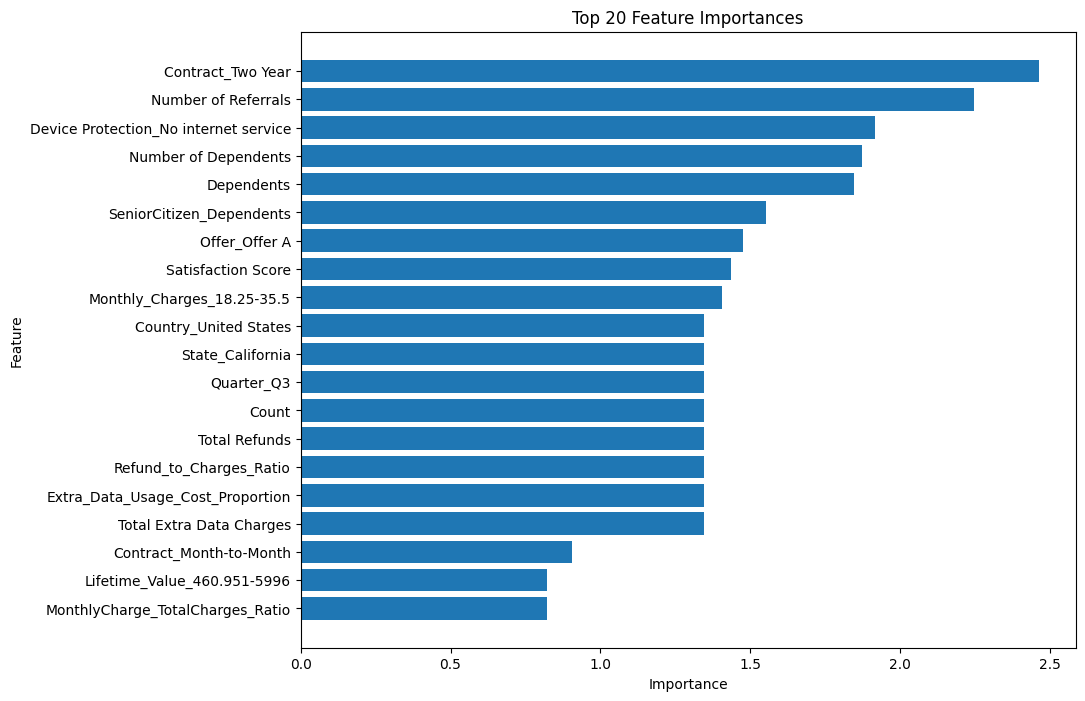

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get the log probabilities of the features given the class
log_prob = best_nb_classifier.feature_log_prob_

# Calculate the importance as the difference between the log probabilities of the two classes
importance = np.abs(log_prob[1] - log_prob[0])

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

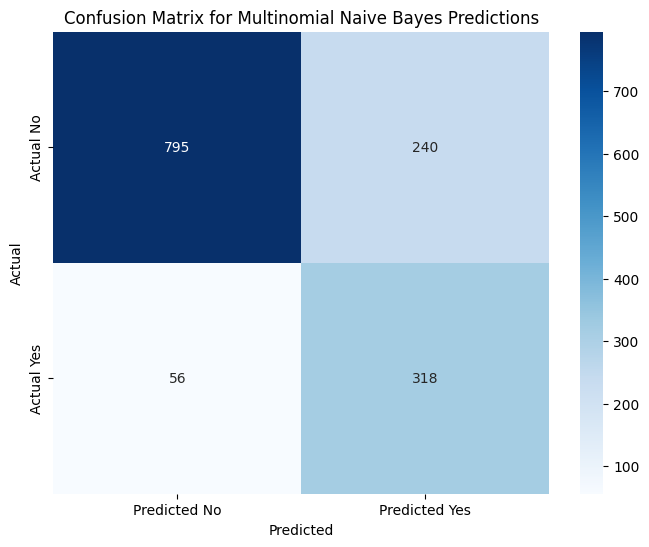

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Multinomial Naive Bayes Predictions')
plt.show()